# This notebook contains the code to make fig 4.3, 4.4 and D.1.

In [1]:
# %matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
from qiskit.quantum_info.states.measures import state_fidelity
import scipy
from simulator_program.custom_transpiler import WACQT_device_properties
from simulator_program.stabilizers import get_encoded_state
from simulator_program.custom_noise_models import  standard_times
from simulator_program import data_analysis_tools, decay

Adding custom device equivalences


/home/sebastian/miniconda3/envs/exjobb-qiskit/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [5]:
# Paramters
n_shots = 1024*8

n_cycles = 15
pauliop = 'ZZZZZ'
gate_times = standard_times

T1 = 40e3
T2 = 60e3

## The cell below will run the simulations for fig 4.3 and 4.4.
## NOTE: **TAKES A VERY LONG TIME, DATA CAN ALSO BE LOADED FURTHER DOWN**

In [ ]:
# Base QEC (hexagonal)
F_L, P_L ,time = data_analysis_tools.fidelity_from_scratch(
    n_cycles, n_shots, T1=T1, T2=T2, encoding=False, project = True)
times = np.array([time['dm_' + str(n)] for n in range(n_cycles)]+[time['end']])
print("Base QEC (hexagonal) done")

# Perfect decoding (no noise in stabilizer cycle)
fidelities_perf, time = data_analysis_tools.perfect_stab_circuit(
    n_cycles, n_shots, T1=T1, T2=T2)
times_perf = np.array([time['dm_' + str(n)] for n in range(n_cycles)]+[time['dm_' + str(n_cycles)]])
print("Perfect decoding (no noise in stabilizer cycle) done")

# Decay single qubit
n_datapoints = 100
timespan = np.linspace(0, times[-1], n_datapoints)
res_1 = decay.get_idle_single_qubit(
    timespan, snapshot_type=['dm'], theta=np.pi, T1=T1, T2=T2)
fid_1_single = [state_fidelity([0, 1], res_1.data()['dm_'+str(index)])
                for index in range(n_datapoints)]
print("Decay single qubit done")

# Decay encoded qubit
res_0 = decay.get_idle_encoded_513(
    timespan, snapshot_type=['dm'], T1=T1, T2=T2)
fid_0_encoded = [state_fidelity(get_encoded_state(0, 0, None), res_0.data()['dm_'+str(index)])
                 for index in range(n_datapoints)]
fid_0_encoded_L = [state_fidelity([1, 0], data_analysis_tools.project_dm_to_logical_subspace_V1(res_0.data()['dm_'+str(index)]))
           for index in range(n_datapoints)]
print("Decay encoded qubit done")

# Post selection
fid_0_ps, counts, time = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots,
    reset=True, data_process_type='post_select',
    idle_noise=True, snapshot_type='dm', encoding=False,
    transpile=True, pauliop='ZZZZZ')
times_ps = np.array([time['dm_con_' + str(n)] for n in range(n_cycles)]+[time['end']])
print("Post selection done")

# Post selection perf decoding 
fid_0_ps_perf, counts_perf, time = data_analysis_tools.perfect_stab_circuit(
    n_cycles, n_shots, T1=T1, T2=T2, data_process_type='post_select')
times_ps_perf = np.array([time['dm_con_' + str(n)] for n in range(n_cycles)]+[time['dm_con_' + str(n_cycles)]])
print("Post selection per decoding done")

# Post selection projected
fid_0_ps_L, P_0_ps_L, counts_L, time = data_analysis_tools.fidelity_from_scratch(
    n_cycles, n_shots, T1=T1, T2=T2, data_process_type='post_select', project= True, encoding=False)
times_ps_L = np.array([time['dm_con_' + str(n)] for n in range(n_cycles)]+[time['dm_con_' + str(n_cycles)]])
# fid_0_ps = fid_0_ps_L*P_0_ps_L
print("Post selection projected done")

# Post selection projected
fid_0_ps_L, P_0_ps_L, counts_L, time = data_analysis_tools.fidelity_from_scratch(
    n_cycles, n_shots, T1=T1, T2=T2, data_process_type='post_select', project= True, encoding=False)
times_ps_L = np.array([time['dm_con_' + str(n)] for n in range(n_cycles)]+[time['dm_con_' + str(n_cycles)]])
# fid_0_ps = fid_0_ps_L*P_0_ps_L
print("Post selection per decoding done")

# Single qubit |+> decay
n_datapoints = 100
timespan = np.linspace(0, times[-1], n_datapoints)
res_p = decay.get_idle_single_qubit(
    timespan, snapshot_type=['dm'], theta=np.pi/2, T1=T1, T2=T2)
fid_p_single = [state_fidelity([1/np.sqrt(2), 1/np.sqrt(2)], res_p.data()['dm_'+str(index)])
                for index in range(n_datapoints)]
print("Single qubit |+> decay done")

# QEC with delay
F_L_d, P_L_d ,time_d = data_analysis_tools.fidelity_from_scratch(
    n_cycles, n_shots, gate_times={'delay':4000} ,T1=T1, T2=T2, encoding=False, project = True)
times_d = np.array([time_d['dm_' + str(n)] for n in range(n_cycles)]+[time_d['end']])
print("Base QEC (hexagonal) done")
fidelities_d = [F_L_i*P_L_i for F_L_i, P_L_i in zip(F_L_d,P_L_d)]
print("QEC with delay done") 

In [ ]:
# SAVE data (if you generated it above)
with open('data/base_qec_data.npy', 'wb') as f:
    np.save(f, (F_L,P_L,times))
    np.save(f, (fidelities_perf,times_perf))
    np.save(f, (fid_1_single,timespan))
    np.save(f, (fid_0_encoded,timespan))
    np.save(f, (fid_0_ps,counts,times_ps))
    np.save(f, (fid_0_ps_perf,counts_perf,times_ps_perf))
    np.save(f, (fid_p_single,timespan))
    np.save(f, (fid_0_ps_L, P_0_ps_L, counts_L, times_ps_L))

In [6]:
# LOAD data (our dataset is included to load)
with open('data/base_qec_data.npy', 'rb') as f:
    F_L,P_L,times = np.load(f)
    fidelities_perf,times_perf = np.load(f)
    fid_1_single,timespan = np.load(f)
    fid_0_encoded,timespan = np.load(f)
    fid_0_ps,counts,times_ps = np.load(f)
    fid_0_ps_perf,counts_perf,times_ps_perf = np.load(f)
    fid_p_single,timespan = np.load(f)
    fid_0_ps_L, P_0_ps_L, counts_L, times_ps_L = np.load(f)

In [7]:
# Exp fit func
def monoExp(t, T, c, A):
    return (A-c) * np.exp(-t/T) + c

def idealExp(t,T):
    return 0.5 * np.exp(-t/T) + 0.5

# Plot colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = plt.get_cmap("tab10")

## Plot fig 4.3

QEC projected $(A-c)e^{-t/T}+c$, T=25.6 μs, A=1, c=0.5
Encoded qubit $(A-c)e^{-t/T}+c$, T=13.3 ns, A=1.00, c=0.044
Post-select $(A-c)e^{-t/T}+c$, T=13.7 μs, A=1.03, c=-0.015
Post-select $(A-c)e^{-t/T}+c$, T=14.0 μs, A=1.03, c=-0.022


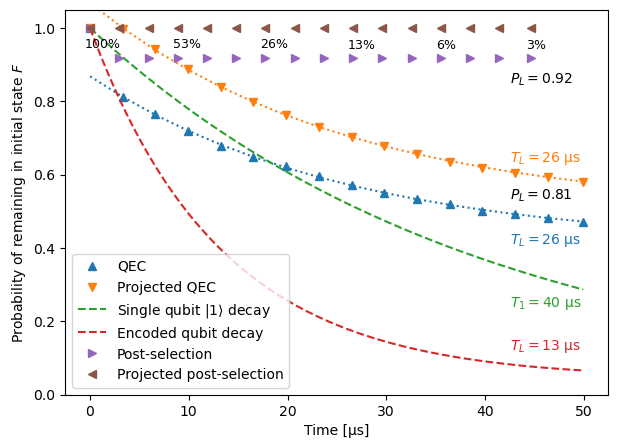

In [9]:
# Setup plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
color_count = 0

# Position of fractions
trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=-0.05, y=-0.3, units='inches')
trans_offset_perf = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=0, y=0.1, units='inches')

trans_offset_lifetime = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=-0.05, y=0.15, units='inches')

# Plot normal QEC
fidelities = [F_L_i*P_L_i for F_L_i, P_L_i in zip(F_L,P_L)]
ax.plot(times/1000, fidelities, '^', color=colors(color_count), label='QEC')
# Exp fit it
p0 = (T1, 0, 0.9)  # start with values near those we expect
pars, cov = scipy.optimize.curve_fit(monoExp, times[1:], fidelities[1:], p0)
T, c, A = pars
ax.text(times[-3]/1000,monoExp(times[-3], *pars), rf'$T_L ={T/1000:.0f}$ μs',color=colors(color_count), transform=trans_offset)
ax.text(times[-3]/1000,monoExp(times[-3], *pars), rf'$P_L ={np.mean(P_L[1:]):.2f}$',color='k', transform=trans_offset_lifetime)
ax.plot(times/1000, monoExp(times, *pars), ':', color=colors(color_count))
color_count += 1

# Plot normal QEC projected
ax.plot(times/1000, F_L, 'v', color=colors(color_count), label='Projected QEC')
# Exp fit it
p0 = T1  # start with values near those we expect
pars_L, cov = scipy.optimize.curve_fit(idealExp, times[1:]-times[1], F_L[1:], p0)
T= pars_L[0]
ax.plot(times/1000, idealExp(times-times[1], *pars_L), ':', color=colors(color_count))

ax.text(times[-3]/1000,idealExp(times[-3], *pars_L), rf'$T_L ={T/1000:.0f}$ μs',color=colors(color_count), transform=trans_offset_lifetime)
print('QEC projected',r'$(A-c)e^{-t/T}+c$,'+f' T={T/1000:.1f} μs, A=1, c=0.5')
color_count += 1

# # Plot P_L
# plt.plot(times/1000, P_L, 's', label='P_L', color=colors(color_count))
# plt.plot(times/1000, monoExp(times, *pars) /
#             idealExp(times-times[1], *pars_L), '--', color=colors(color_count))
# color_count += 1

# Plot single qubit decay |1>
ax.plot(timespan/1000, fid_1_single, '--',
        color=colors(color_count), label=r'Single qubit $|1\rangle$ decay')
trans_offset_lifetime = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=-0.05, y=-0.20, units='inches')
ax.text(times_perf[-3]/1000,fid_1_single[-3],rf'$T_1 ={T1/1000:.0f}$ μs',color=colors(color_count), transform=trans_offset_lifetime)
color_count += 1

# # Plot single qubit decay |+>
# ax.plot(timespan/1000, fid_p_single, '--',
#         color=colors(color_count), label=r'Single qubit $|+\rangle$ decay')
# trans_offset_lifetime = mtransforms.offset_copy(ax.transData, fig=fig,
#                                        x=-0.05, y=-0.20, units='inches')
# ax.text(times_perf[-3]/1000,fid_p_single[-3],rf'$T_2 ={T2/1000:.0f}$ μs',color=colors(color_count), transform=trans_offset_lifetime)
# color_count += 1

# Plot encoded qubit decay
ax.plot(timespan/1000, fid_0_encoded, '--',
        color=colors(color_count), label='Encoded qubit decay')
p0 = (T1, 0, 0.9) # start with values near those we expect
pars, cov = scipy.optimize.curve_fit(monoExp, timespan[:-5], fid_0_encoded[:-5], p0)
T, c, A = pars
trans_offset_lifetime = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=-0.05, y=0.20, units='inches')
ax.text(times_perf[-3]/1000,fid_0_encoded[-3],rf'$T_L ={T/1000:.0f}$ μs',color=colors(color_count), transform=trans_offset_lifetime)
print('Encoded qubit',r'$(A-c)e^{-t/T}+c$,'+f' T={T/1000:.1f} ns, A={A:.2f}, c={c:.3f}')
color_count += 1

# # Plot encoded qubit decay projected
# ax.plot(timespan/1000, fid_0_encoded_L, '--',
#         color=colors(color_count), label='Encoded qubit decay projected')
# color_count += 1


# Plot post select
ax.plot(times_ps/1000, fid_0_ps, '>', color=colors(color_count), label='Post-selection')
# Exp fit it
p0 = (T1, 0, 0.9)  # start with values near those we expect
pars, cov = scipy.optimize.curve_fit(monoExp, times_ps, np.array(counts)/n_shots, p0)
T, c, A = pars
print('Post-select',r'$(A-c)e^{-t/T}+c$,'+f' T={T/1000:.1f} μs, A={A:.2f}, c={c:.3f}')
# Fractions
trans_offset_down = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=-0.05, y=-0.25, units='inches')
# for i,(x, y, text) in enumerate(zip(times_ps,fid_0_ps, counts)):
#     if i == 0:
#         continue
#     if i%3==0:
#         plt.text(x/1000, y, f'{text/n_shots*100:.0f}%', size =9 ,color='k',transform=trans_offset_down)
color_count += 1

ax.text(times[-3]/1000,fid_0_ps[-3], rf'$P_L ={np.mean(P_0_ps_L[1:]):.2f}$',color='k', transform=trans_offset_down)

# Plot post select projected
ax.plot(times_ps/1000, fid_0_ps_L, '<', color=colors(color_count), label='Projected post-selection')
# Exp fit it
p0 = (T1, 0, 0.9)  # start with values near those we expect
pars, cov = scipy.optimize.curve_fit(monoExp, times_ps, np.array(counts_L)/n_shots, p0)
T, c, A = pars
print('Post-select',r'$(A-c)e^{-t/T}+c$,'+f' T={T/1000:.1f} μs, A={A:.2f}, c={c:.3f}')
# Fractions
trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=-0.05, y=-0.2, units='inches')
for i,(x, y, text) in enumerate(zip(times_ps,fid_0_ps_L, counts_L)):
    # if i == 0:
    #     continue
    if i%3==0:
        plt.text(x/1000, y, f'{text/n_shots*100:.0f}%', size =9 ,transform=trans_offset)
color_count += 1

ax.set_xlabel('Time [μs]')
ax.set_ylabel(r'Probability of remaining in initial state $F$')
ax.set_ylim((0,1.05))
ax.legend()
plt.show()


## Plot fig 4.4

QEC perf decoding $(A-c)e^{-t/T}+c$, T=118009 ns, A=1.00, c=0.508
Post-select $(A-c)e^{-t/T}+c$, T=13.7 μs, A=1.03, c=-0.015
Post-select and project $(A-c)e^{-t/T}+c$, T=13801 μs, A=1.00, c=-0.001


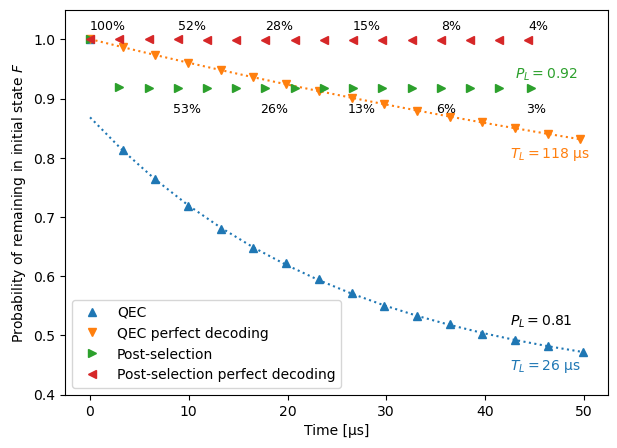

In [10]:
# Setup plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = plt.get_cmap("tab10")
color_count = 0

# Position of fractions
trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=-0.05, y=-0.3, units='inches')
trans_offset_perf = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=0, y=0.1, units='inches')

trans_offset_lifetime = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=-0.05, y=0.15, units='inches')

# Plot normal QEC
fidelities = [F_L_i*P_L_i for F_L_i, P_L_i in zip(F_L,P_L)]
ax.plot(times/1000, fidelities, '^', color=colors(color_count), label='QEC')
# Exp fit it
p0 = (T1, 0, 0.9)  # start with values near those we expect
pars, cov = scipy.optimize.curve_fit(monoExp, times[1:], fidelities[1:], p0)
T, c, A = pars
ax.text(times[-3]/1000,monoExp(times[-3], *pars), rf'$T_L ={T/1000:.0f}$ μs',color=colors(color_count), transform=trans_offset)
ax.text(times[-3]/1000,monoExp(times[-3], *pars), rf'$P_L ={np.mean(P_L[1:]):.2f}$',color='k', transform=trans_offset_lifetime)
ax.plot(times/1000, monoExp(times, *pars), ':', color=colors(color_count))
color_count += 1

# # Plot P_L
# plt.plot(times/1000, P_L, 's', label='P_L', color=colors(color_count))
# plt.plot(times/1000, monoExp(times, *pars) /
#             idealExp(times-times[1], *pars_L), '--', color=colors(color_count))
# color_count += 1


# Plot perf decoding QEC
ax.plot(times_perf/1000, fidelities_perf, 'v', color=colors(color_count), label='QEC perfect decoding')
# Exp fit it
p0 = (T1, 0, 0.9)  # start with values near those we expect
pars, cov = scipy.optimize.curve_fit(monoExp, times_perf, fidelities_perf, p0)
T, c, A = pars
ax.plot(times_perf/1000, monoExp(times_perf, *pars), ':', color=colors(color_count))
ax.text(times_perf[-3]/1000,monoExp(times_perf[-3], *pars),rf'$T_L ={T/1000:.0f}$ μs',color=colors(color_count), transform=trans_offset)
print('QEC perf decoding',r'$(A-c)e^{-t/T}+c$,'+f' T={T:.0f} ns, A={A:.2f}, c={c:.3f}')
color_count += 1

# # Plot single qubit decay |1>
# ax.plot(timespan/1000, fid_1_single, '--',
#         color=colors(color_count), label=r'Single qubit $|1\rangle$ decay')
# trans_offset_lifetime = mtransforms.offset_copy(ax.transData, fig=fig,
#                                        x=-0.05, y=-0.20, units='inches')
# ax.text(times_perf[-3]/1000,fid_1_single[-3],rf'$T_1 ={T1/1000:.0f}$ μs',color=colors(color_count), transform=trans_offset_lifetime)
# color_count += 1

# # Plot single qubit decay |+>
# ax.plot(timespan/1000, fid_p_single, '--',
#         color=colors(color_count), label=r'Single qubit $|+\rangle$ decay')
# trans_offset_lifetime = mtransforms.offset_copy(ax.transData, fig=fig,
#                                        x=-0.05, y=-0.20, units='inches')
# ax.text(times_perf[-3]/1000,fid_p_single[-3],rf'$T_2 ={T2/1000:.0f}$ μs',color=colors(color_count), transform=trans_offset_lifetime)
# color_count += 1

# # Plot encoded qubit decay
# ax.plot(timespan/1000, fid_0_encoded, '--',
#         color=colors(color_count), label='Encoded qubit decay')
# p0 = (T1, 0, 0.9) # start with values near those we expect
# pars, cov = scipy.optimize.curve_fit(monoExp, timespan[:-5], fid_0_encoded[:-5], p0)
# T, c, A = pars
# trans_offset_lifetime = mtransforms.offset_copy(ax.transData, fig=fig,
#                                        x=-0.05, y=0.20, units='inches')
# ax.text(times_perf[-3]/1000,fid_0_encoded[-3],rf'$T_L ={T/1000:.0f}$ μs',color=colors(color_count), transform=trans_offset_lifetime)
# print('Encoded qubit',r'$(A-c)e^{-t/T}+c$,'+f' T={T/1000:.1f} ns, A={A:.2f}, c={c:.3f}')
# color_count += 1

# # Plot encoded qubit decay projected
# ax.plot(timespan/1000, fid_0_encoded_L, '--',
#         color=colors(color_count), label='Encoded qubit decay projected')
# color_count += 1


# Plot post select
ax.plot(times_ps/1000, fid_0_ps, '>', color=colors(color_count), label='Post-selection')
# Exp fit it
p0 = (T1, 0, 0.9)  # start with values near those we expect
pars, cov = scipy.optimize.curve_fit(monoExp, times_ps, np.array(counts)/n_shots, p0)
T, c, A = pars
print('Post-select',r'$(A-c)e^{-t/T}+c$,'+f' T={T/1000:.1f} μs, A={A:.2f}, c={c:.3f}')
# Fractions
trans_offset_down = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=-0.05, y=-0.25, units='inches')
for i,(x, y, text) in enumerate(zip(times_ps,fid_0_ps, counts)):
    if i == 0:
        continue
    if i%3==0:
        plt.text(x/1000, y, f'{text/n_shots*100:.0f}%', size =9 ,color='k',transform=trans_offset_down)
ax.text(times[-3]/1000,fid_0_ps[-3], rf'$P_L ={np.mean(P_0_ps_L[1:]):.2f}$',color=colors(color_count), transform=trans_offset_perf)
color_count += 1

# # Plot post select projected
# ax.plot(times_ps/1000, fid_0_ps_L, '<', color=colors(color_count), label='Projected post-selection')
# # Exp fit it
# p0 = (T1, 0, 0.9)  # start with values near those we expect
# pars, cov = scipy.optimize.curve_fit(monoExp, times_ps, np.array(counts_L)/n_shots, p0)
# T, c, A = pars
# print('Post-select',r'$(A-c)e^{-t/T}+c$,'+f' T={T/1000:.1f} μs, A={A:.2f}, c={c:.3f}')
# # Fractions
# trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
#                                        x=-0.05, y=-0.2, units='inches')
# for i,(x, y, text) in enumerate(zip(times_ps,fid_0_ps_L, counts_L)):
#     # if i == 0:
#     #     continue
#     if i%3==0:
#         plt.text(x/1000, y, f'{text/n_shots*100:.0f}%', size =9 ,transform=trans_offset)
# color_count += 1


# Plot post select perf decoding
ax.plot(times_ps_perf/1000, fid_0_ps_perf, '<', color=colors(color_count), label='Post-selection perfect decoding')
# Exp fit it
p0 = (T1, 0, 0.9)  # start with values near those we expect
pars, cov = scipy.optimize.curve_fit(monoExp, times_ps_perf, np.array(counts_perf)/n_shots, p0)
T, c, A = pars
print('Post-select and project',r'$(A-c)e^{-t/T}+c$,'+f' T={T:.0f} μs, A={A:.2f}, c={c:.3f}')
# Fractions
for i,(x, y, text) in enumerate(zip(times_ps_perf,fid_0_ps_perf, counts_perf)):
    if i%3==0:
        plt.text(x/1000, y, f'{text/n_shots*100:.0f}%', size =9, color='k',transform=trans_offset_perf)
color_count += 1

ax.set_xlabel('Time [μs]')
ax.set_ylabel(r'Probability of remaining in initial state $F$')
ax.set_ylim((0.4,1.05))
ax.legend()
plt.show()
fig.savefig('base_presentation.pdf')

## Fig D.1. No-reset vs reset runs (Post-Processing). This one has no loadable data and needs to be run!

In [11]:
# Generate data
n_cycles=12
n_shots=1024*4
fid_rec, time_rec = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots, gate_times=standard_times,
    reset=True, data_process_type='recovery',
    idle_noise=True, snapshot_type='dm', encoding=False, theta=0, phi=0,
    transpile=False, pauliop='ZZZZZ', device_properties=WACQT_device_properties,
    device=None, simulator_type='density_matrix',move_feedback_delay=True)
print('Check!')
fid_r, time_r = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots, gate_times=standard_times,
    reset=True, data_process_type='post_process',
    idle_noise=True, snapshot_type='dm', encoding=False, theta=0, phi=0,
    transpile=False, pauliop='ZZZZZ', device_properties=WACQT_device_properties,
    device=None, simulator_type='density_matrix',move_feedback_delay=True)
print('Check!')
fid, time = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots, gate_times=standard_times,
    reset=False, data_process_type='post_process',
    idle_noise=True, snapshot_type='dm', encoding=False, theta=0, phi=0,
    transpile=False, pauliop='ZZZZZ', device_properties=WACQT_device_properties,
    device=None, simulator_type='density_matrix',move_feedback_delay=True)
print('Check!')

Check!
Check!
Check!


25617.988882123995
0.4156113584452147
1274.979228162591
29993.017988191943
0.3918147749421371
922.1566759092335
26031.52399054703
0.40528802391506646
1191.0952149951668


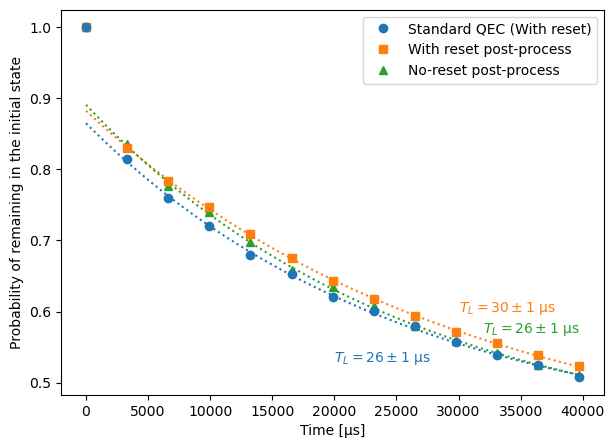

In [12]:
# Plot data
time = [time_rec['dm_'+str(i)] for i in range(n_cycles+1)]
fig, ax = plt.subplots(1,1, figsize=(7, 5))

# Subplot 1: Target gate times
ax.plot(time, fid_rec, 'o', color='C0', label='Standard QEC (With reset)', zorder=10)
ax.plot(time, fid_r, 's', color='C1', label='With reset post-process', zorder=5)
ax.plot(time, fid, '^', color='C2', label='No-reset post-process', zorder=0)

ax.set_xlabel('Time [μs]')
#ax.set_ylabel(r'Average state fidelity of $|0_L\rangle$')
ax.set_ylabel('Probability of remaining in the initial state')
ax.legend()
 
fid_list = [fid_rec, fid_r, fid]
t = np.linspace(time[0], time[-1], 100)
lifetimes = []
for i in range(len(fid_list)):
    p0 = (40e3, 0, 0.9) # start with values near those we expect
    x= time
    y = fid_list[i]
    pars, cov = scipy.optimize.curve_fit(monoExp, x[1:], y[1:], p0)
    T, c, A = pars
    lifetimes.append(T)
    ax.plot(t, monoExp(t, *pars), ':', color='C'+str(i))
    print(T)
    print(c)
    print(np.sqrt(cov[0][0])) # One standard deviation
ax.text(20000, 0.53,rf'$T_L ={lifetimes[0]/1000:.0f} \pm 1$ μs', color='C0')
ax.text(30000, 0.6,rf'$T_L ={lifetimes[1]/1000:.0f} \pm 1$ μs', color='C1')
ax.text(32000, 0.57,rf'$T_L ={lifetimes[2]/1000:.0f} \pm 1$ μs', color='C2')
plt.show()